To make the model even more complex we will:
1) Add a Convolutional layer followed by a batch normalization, relu and a dropout2d layer.
2) Add residual (skip) blocks

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import json, re
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.optim as optim # for PyTorch optimizers
import math
from torch.utils.data import Subset, ConcatDataset
import os, random, numpy as np
from torchvision import transforms, datasets 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


SEED = 42

# Python and NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)


# Apple Silicon (MPS) - safe to call regardless of MPS availability
if hasattr(torch, "mps") and torch.backends.mps.is_available():
    torch.manual_seed(SEED)

# Deterministic behavior (may reduce speed; some ops may still be nondeterministic)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False





class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, drop_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.drop = nn.Dropout2d(drop_p) if drop_p and drop_p > 0 else nn.Identity()

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.drop(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)
        return out


In [2]:
class ResCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # keep 16 channels, same spatial size
        self.stage1 = nn.Sequential(
            BasicBlock(16, 16, stride=1, drop_p=0.0),
            BasicBlock(16, 16, stride=1, drop_p=0.0),
        )

        # go 16 -> 32 and downsample (stride=2 does both, with projection)
        self.stage2 = nn.Sequential(
            BasicBlock(16, 32, stride=2, drop_p=0.1),
            BasicBlock(32, 32, stride=1, drop_p=0.1),
        )

        # go 32 -> 64 and downsample again
        self.stage3 = nn.Sequential(
            BasicBlock(32, 64, stride=2, drop_p=0.2),
            BasicBlock(64, 64, stride=1, drop_p=0.2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.LazyLinear(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.classifier(x)
        return x


In [ ]:
# Load datasets 

img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(
        brightness = 0.2,
        saturation = 0.2,
        contrast = 0.2,
        hue = 0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
])


train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
val_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val", transform=train_transform)

full_ds = ConcatDataset([train_ds_local, val_ds_local])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
indices = np.arange(len(full_ds))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
history = {
    "fold": [],
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

fold_summary = []  # one row per fold (e.g., best/last metrics)

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f'Fold {fold + 1}')
    train_subset = Subset(full_ds, train_idx)
    val_subset   = Subset(full_ds, val_idx)

    cnn = ResCNN()
    cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr = 0.0005115859153484923, momentum = 0.9)

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size = 16,
        shuffle = True,
        num_workers = 2,
    )
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size = 16,
        shuffle = False,
        num_workers = 2,
    )

    best_val_loss = math.inf
    best_val_acc = 0.0

    for epoch in range(20):

        print(f'Training epoch {epoch}...')
        cnn.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        n_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(inputs)
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            n_train += labels.size(0)

        train_loss = running_loss / max(n_train, 1)
        train_acc  = train_correct / max(train_total, 1)
        
        print(f'Loss = {round(train_loss, 4)}, Accuracy = {round(train_acc, 4)}')

        cnn.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / max(total, 1)
        val_acc = correct / max(total, 1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        history["fold"].append(fold + 1)
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)


        print(f'Validation accuracy: {val_acc}')
    
    fold_summary.append({
    "fold": fold + 1,
    "best_val_loss": best_val_loss,
    "best_val_acc": best_val_acc,
    "last_val_loss": val_loss,
    "last_val_acc": val_acc,
        })

Training epoch 0...
Loss = 1.11
Validation accuracy: 0.549079754601227
Training epoch 1...
Loss = 0.9358
Validation accuracy: 0.8220858895705522
Training epoch 2...
Loss = 0.6474
Validation accuracy: 0.9079754601226994
Training epoch 3...
Loss = 0.5357
Validation accuracy: 0.8834355828220859
Training epoch 4...
Loss = 0.41
Validation accuracy: 0.9447852760736196
Training epoch 5...
Loss = 0.3518
Validation accuracy: 0.9601226993865031
Training epoch 6...
Loss = 0.2632
Validation accuracy: 0.9631901840490797
Training epoch 7...
Loss = 0.245
Validation accuracy: 0.9785276073619632
Training epoch 8...
Loss = 0.2073
Validation accuracy: 0.9754601226993865
Training epoch 9...
Loss = 0.2064
Validation accuracy: 0.9693251533742331
Training epoch 10...
Loss = 0.1636
Validation accuracy: 0.9785276073619632
Training epoch 11...
Loss = 0.1342
Validation accuracy: 0.9601226993865031
Training epoch 12...
Loss = 0.1471
Validation accuracy: 0.9754601226993865
Training epoch 13...
Loss = 0.1532
Valida

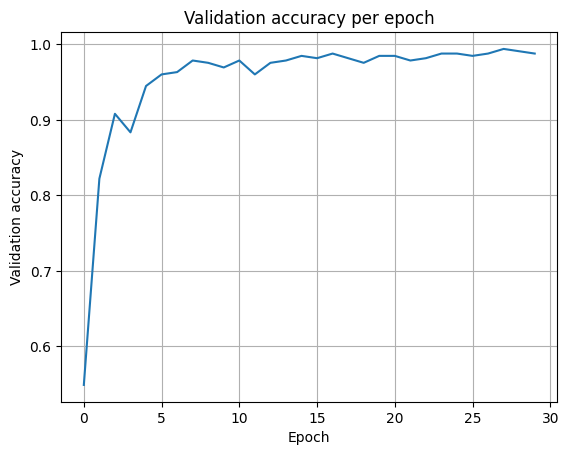

In [12]:
path = "CNN3.ipynb"   # same folder as the notebook file
with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# Collect all stdout text saved in outputs
texts = []
for cell in nb.get("cells", []):
    for out in cell.get("outputs", []):
        if out.get("output_type") == "stream" and out.get("name") == "stdout":
            texts.extend(out.get("text", []))

blob = "".join(texts)

val_acc = [float(x) for x in re.findall(r"Validation accuracy:\s*([0-9]*\.?[0-9]+)", blob)]

plt.plot(range(len(val_acc)), val_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy per epoch")
plt.grid(True)
plt.show()


In [13]:

torch.save(cnn.state_dict(), 'trained_res_cnn.pth')

In [14]:


TEST_DIR = "/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test"  


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


img_size = (256, 256)
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load test set
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)
print("Test classes:", test_ds.classes, "  n_test:", len(test_ds))


cnn = ResCNN().to(device)
cnn.load_state_dict(torch.load("trained_res_cnn.pth", map_location=device))
cnn.eval()


# Dataloader (you can use best batchsize or set your own)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=2,
)

# Evaluate
criterion = nn.CrossEntropyLoss()
total, correct, test_loss_sum = 0, 0, 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = cnn(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        test_loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += bs

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss = test_loss_sum / max(total, 1)
test_acc = correct / max(total, 1)


print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test classes: ['paper', 'rock', 'scissors']   n_test: 331
Test loss: 0.0810
Test accuracy: 0.9909


Confusion matrix (counts):
 [[105   2   1]
 [  0 110   0]
 [  0   0 113]]


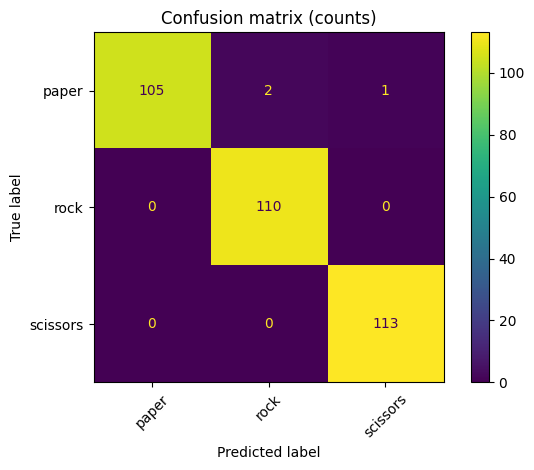

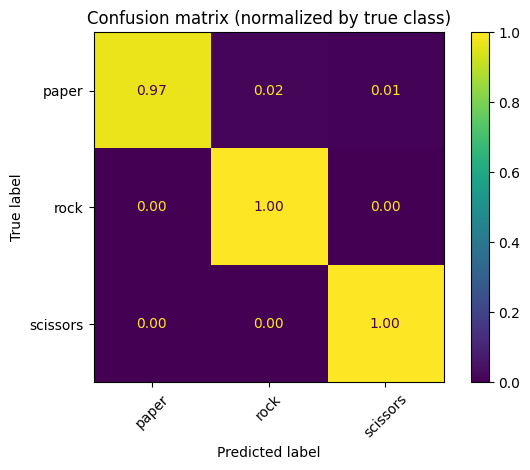


Classification report:
              precision    recall  f1-score   support

       paper     1.0000    0.9722    0.9859       108
        rock     0.9821    1.0000    0.9910       110
    scissors     0.9912    1.0000    0.9956       113

    accuracy                         0.9909       331
   macro avg     0.9911    0.9907    0.9908       331
weighted avg     0.9911    0.9909    0.9909       331



In [15]:
# Concatenate the tensors you collected during evaluation
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)  # C[i, j] = # true=i predicted=j [web:20]
print("Confusion matrix (counts):\n", cm)

# Optional: normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize='true' -> row-normalized [web:20]

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()  # ConfusionMatrixDisplay is intended for plotting a confusion matrix [web:27]

# Plot (row-normalized)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=test_ds.classes)
disp_norm.plot(xticks_rotation=45, values_format=".2f")
plt.title("Confusion matrix (normalized by true class)")
plt.tight_layout()
plt.show()  # normalize option controls how entries are normalized [web:27]

# Classification report (precision/recall/F1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))  # target_names labels classes [web:19]


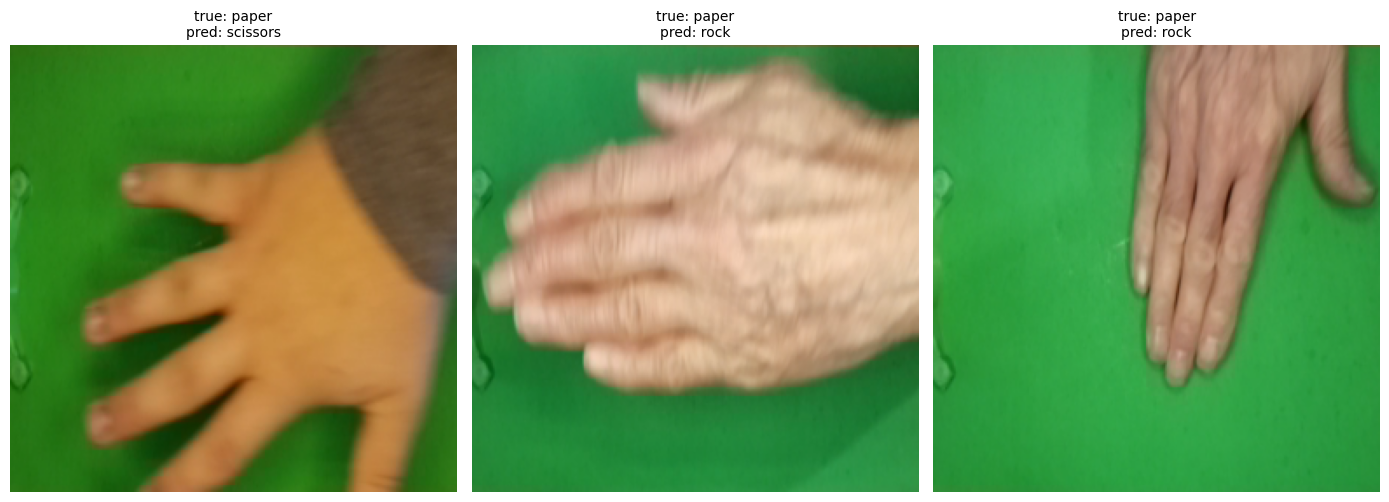

In [ ]:
# helper: unnormalize for display (matches your Normalize(mean=0.5, std=0.5)) ----
def denorm(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # img: (C,H,W)
    mean = torch.tensor(mean).view(-1, 1, 1)
    std  = torch.tensor(std).view(-1, 1, 1)
    return img * std + mean

@torch.no_grad()
def collect_misclassified(model, loader, device, class_names, max_samples = None):
    model.eval()
    wrong = []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        mis_mask = preds.ne(y)
        if mis_mask.any():
            xs = x[mis_mask].cpu()
            ys = y[mis_mask].cpu()
            ps = preds[mis_mask].cpu()

            for xi, yi, pi in zip(xs, ys, ps):
                wrong.append((xi, int(yi), int(pi)))
                if len(wrong) >= max_samples:
                    return wrong
    return wrong

def plot_misclassified(wrong, class_names, ncols=5, figsize=(14, 10)):
    if len(wrong) == 0:
        print("No misclassified images found.")
        return

    n = len(wrong)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.ravel() if n > 1 else [axes]

    for i, ax in enumerate(axes):
        if i >= n:
            ax.axis("off")
            continue

        img, y_true, y_pred = wrong[i]

        img = denorm(img).clamp(0, 1)          # back to [0,1]
        img = img.permute(1, 2, 0).numpy()     # HWC for matplotlib

        ax.imshow(img)
        ax.set_title(f"true: {class_names[y_true]}\npred: {class_names[y_pred]}", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Usage with your objects from the notebook 
wrong = collect_misclassified(
    model=cnn,
    loader=test_loader,
    device=device,
    class_names=test_ds.classes,
    max_samples=25
)

plot_misclassified(wrong, class_names=test_ds.classes, ncols=5, figsize=(14, 10))
